In [75]:
import numpy as np

def matrix_with_singular_values(s, m, n):
    s = np.array(s)
    k = s.size
    if k != min(m, n):
        raise ValueError("Length of s must be equal to min(m, n)")
    
    s_sorted = np.sort(s)[::-1]
    
    U, _ = np.linalg.qr(np.random.randn(m, m))
    V, _ = np.linalg.qr(np.random.randn(n, n))
    
    Sigma = np.zeros((m, n))
    np.fill_diagonal(Sigma, s_sorted)
    
    A = U @ Sigma @ V.T
    return A

||x_m - x*|| / ||x*|| =  3050556893.705208


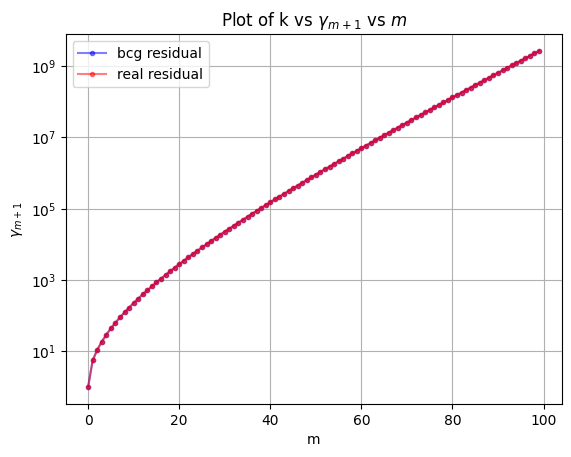

In [86]:
import numpy as np 
import matplotlib.pyplot as plt

def bcg(A,x0,b, max_iter=10000,tol=1e-6):
    residual_norms = np.array([])
    real_residuals = np.array([])
    N = np.size(b)
    x_j = x0
    r0 = b - A@x0
    r_j = r0
    r_c_j = r_j
    j_max = 0
    p_j = r_j
    p_c_j = r_c_j
    for j in np.arange(0,N):
        # print("||r_j||/||r_0|| = ", np.linalg.norm(r_j)/np.linalg.norm(r0))
        residual_norms = np.append(residual_norms, np.linalg.norm(r_j)/np.linalg.norm(r0))
        real_residuals = np.append(real_residuals, np.linalg.norm(b - A@x_j) / np.linalg.norm(r0))
        j_max = j
        if (np.linalg.norm(r_j) / np.linalg.norm(r0) < tol):
            break
        alpha_j = np.dot(r_j,r_c_j)/np.dot(A@p_j,p_c_j)
        x_jp1 = x_j + alpha_j*p_j
        r_jp1 = r_j - alpha_j*A@p_j
        r_c_jp1 = r_c_j -  alpha_j*(A.conj())@p_c_j
        beta_j = np.dot(r_jp1, r_c_jp1) / np.dot(r_j,r_c_j)
        p_jp1 = r_j + beta_j*p_j
        p_c_jp1 = r_c_j + beta_j*p_c_j

        x_j = x_jp1
        r_j = r_jp1
        r_c_j = r_c_jp1
        p_j = p_jp1
        p_c_j = p_c_jp1

    print("||x_m - x*|| / ||x*|| = ", np.linalg.norm(x_j - np.linalg.solve(A,b)) / np.linalg.norm(np.linalg.solve(A,b)))
    plt.plot(np.arange(0, j_max+1), residual_norms, marker='o', markersize=3, linestyle='-', color='b', alpha=0.5, label='bcg residual')
    plt.plot(np.arange(0, j_max+1), real_residuals, marker='o', markersize=3, linestyle='-', color='r', alpha=0.5, label='real residual')


    plt.title(r'Plot of k vs $\gamma_{m+1}$ vs $m$')
    plt.xlabel('m')
    plt.ylabel(r'$\gamma_{m+1}$')
    plt.semilogy()
    plt.grid()
    plt.legend()
    plt.show()
    

N = 100
A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N)
b = np.random.rand(N)
x0 = np.zeros(N)

bcg(A,x0,b)

||x_m - x*|| / ||x*|| =  1.1748754111603634


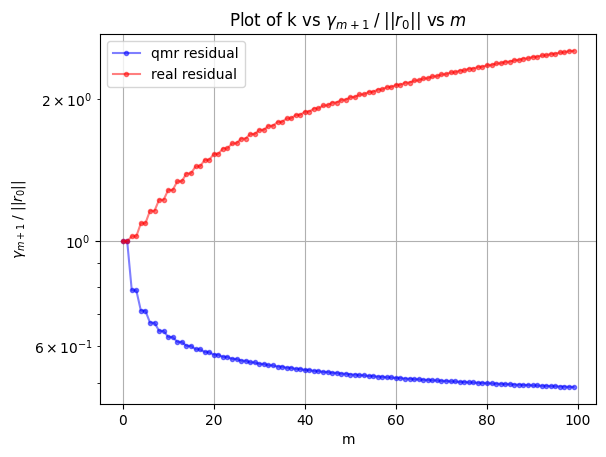

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def qmr(A, b, x0, max_iter=10000, tol=1e-6):
    N = np.size(b)
    r0 = b - A@x0
    x_mm1 = x0
    x_m = x0 
    gamma_m = np.linalg.norm(r0)
    w_mm1 = np.zeros(N)
    v_mm1 = np.zeros(N)
    v_m = r0/gamma_m
    w_m = r0/gamma_m
    beta_m = 0
    delta_m = 0

    c_mm2 = 1.0
    s_mm2 = 0.0
    c_mm1 = 1.0
    s_mm1 = 0.0

    p_mm2 = np.zeros(N)
    p_mm1 = np.zeros(N)

    g = np.array([1.0])
    real_residuals = np.array([1.0])
    mmax = 0

    for m in np.arange(1, N):
        alpha_m = np.dot(A@v_m,w_m)
        v_mp1_hat = A@v_m - alpha_m*v_m - beta_m*v_mm1
        w_mp1_hat = A.conj()@w_m - alpha_m*w_m - delta_m*w_mm1
        delta_mp1 = np.sqrt(np.abs(np.dot(v_mp1_hat,w_mp1_hat)))
        if delta_mp1 < tol:
            break
        beta_mp1 = np.dot(v_mp1_hat,w_mp1_hat) / delta_mp1
        v_mp1 = v_mp1_hat / delta_mp1
        w_mp1 = w_mp1_hat / beta_mp1

        t_m_m_mm1 = -beta_m*c_mm2*s_mm1 + alpha_m*c_mm1
        sc_m_denom = np.sqrt( (t_m_m_mm1)**2 + (delta_mp1)**2 )
        s_m = delta_mp1 / sc_m_denom
        c_m = ( t_m_m_mm1 ) / sc_m_denom

        gamma_mp1 = -s_m*gamma_m
        g = np.append(g, np.abs(gamma_mp1)/np.linalg.norm(r0))
        gamma_m = c_m * gamma_m

        t_m_m = c_m * t_m_m_mm1 + s_m * delta_mp1
        t_mm1_m = beta_m*c_mm2*c_mm1 + alpha_m*s_mm1

        p_m = 1/t_m_m * (v_m - (beta_m*s_mm2)*p_mm2 - t_mm1_m*p_mm1)

        x_m = x_mm1 + gamma_m * p_m
        
        real_residuals = np.append(real_residuals, np.linalg.norm(b - A@x_m) / np.linalg.norm(r0))

        mmax = m
        if g[-1] < tol:
            break
        
        x_mm1 = x_m
        gamma_m = gamma_mp1
        v_mm1 = v_m
        v_m = v_mp1
        w_mm1 = w_m
        w_m = w_mp1
        p_mm2 = p_mm1
        p_mm1 = p_m
        delta_m = delta_mp1
        beta_m = beta_mp1
        c_mm2 = c_mm1
        c_mm1 = c_m
        s_mm2 = s_mm1
        s_mm1 = s_m
        
    print("||x_m - x*|| / ||x*|| = ", np.linalg.norm(x_m - np.linalg.solve(A,b)) / np.linalg.norm(np.linalg.solve(A,b)))
    plt.plot(np.arange(0, mmax+1), g, marker='o', markersize=3, linestyle='-', color='b', alpha=0.5, label='qmr residual')
    plt.plot(np.arange(0, mmax+1), real_residuals, marker='o', markersize=3, linestyle='-', color='r', alpha=0.5, label='real residual')
    plt.title(r'Plot of k vs $\gamma_{m+1} \;/\; ||r_0||$ vs $m$')
    plt.xlabel('m')
    plt.ylabel(r'$\gamma_{m+1} \;/\; ||r_0||$')
    plt.semilogy()
    plt.grid()
    plt.legend()
    plt.show()

    
N = 100
A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N)
b = np.random.rand(N)
x0 = np.zeros(N)
qmr(A, b, x0)